# Project 2 : Human Activity Recognition

### 프로젝트 제출 가이드
- 제출 기한: 2023년 8월 10일 (목) 자정
- 구현 사항:
  - 성능이 잘 나오도록 [3. Feature Extraction](#3.-Feature-Extraction) 셀의 `extract_features` 함수 수정
  - [4. Classifiers](#4.-Classifiers) 셀에 5가지 분류기들을 구현
- 제출 파일: 출력이 포함된 `Project2.ipynb` (여러 번 제출시 마지막 버전을 사용)
- 제출 방법: `X조 ML Project 2` 제목으로 `ta_ml@hcs.snu.ac.kr`에 이메일 제출
- 점수 비중: 전체의 30%


### 채점 기준 [총 100점]
1. `LRClassifier`, `LDAClassifier`, `RFClassifier`, `BClassifier`, `SVMClassifier` 각 분류기당 [+20점]
  1. 수행 [+15점] : [5. Cross-validation with Subjects](#5.-Cross-validation-with-Subjects) 셀이 잘 수행되어야 하고, 분류기들은 각각 아래 주어진 방식으로 분류를 수행해야 합니다.
      - `LRClassifier` : Logistic Regression
      - `LDAClassifier` : Linear Discriminant Analysis
      - `RFClassifier` : Random Forest
      - `BClassifier` : Boosting with Decision Tree
      - `SVMClassifier` : Support Vector Machines
  2. 성능 [+5점]
    - 주어지지 않은 별개의 테스트 데이터를 이용해 각 분류기의 성능을 평가합니다. 각 분류기마다 팀별 상대적 성능을 고려해서 0점 ~ 5점 사이로 정해집니다. 팀별 성능을 점수로 변환하는 과정은 아래 코드를 참고해주세요.

    ```python
    import numpy as np
    from scipy import stats

    # Assume there are 5 teams. Example for single classifier.
    macro_f1_score_of_each_team = [0.9, 0.8, 0.5, 0.6, 0.65]

    # 1. Standardize f1 scores
    zscore = stats.zscore(macro_f1_score_of_each_team)
    # 2. Convert standardized f1 scores to 0 ~ 5 points
    score = 5 * (zscore - np.min(zscore)) / (np.max(zscore) - np.min(zscore))

    print(score)  # score = [5, 3.75, 0, 1.25, 1.875]
    ```

2. 띄어쓰기, 주석, Data Plotting 등 실행과 상관없는 부분은 수정이 가능하고, 실행과 관련된 부분은 [3. Feature Extraction](#3.-Feature-Extraction), [4. Classifiers](#4.-Classifiers) 두 부분만 수정하여야 합니다. [-50점]


### 참고 사항
- 이전 성능이 좋았던 팀들의 경우 각 분류기들의 Cross-validation macro F1 score는 0.65 정도 나왔습니다.

---
## 목차
1. [Project Overview](#1.-Project-Overview)
2. [Data Preparation](#2.-Data-Preparation)
3. [Feature Extraction](#3.-Feature-Extraction)
4. [Classifiers](#4.-Classifiers)
5. [Cross-validation with Subjects](#5.-Cross-validation-with-Subjects)

### 1. Project Overview
- 5초간 손목의 가속도계 센서 데이터를 이용해서 그 사람의 행동을 예측하는 분류기를 만듭니다.

<img src="https://gitlab.com/machine-learning-course1/ml-project-samsung-2023-summer/-/raw/master/images/simple_pipeline.png" style='width:70%; margin-bottom:10px'>
<div style='text-align:center; font-weight:bold;'>그림 1. Walking, Running 예제 데이터</div>

### Import libraries

In [3]:
import pickle
from urllib.request import urlopen

import matplotlib.pyplot as plt
import numpy as np
from sklearn.model_selection import cross_val_score, LeaveOneGroupOut
%matplotlib inline

### 2. Data Preparation
#### 2.1. Data Load
- 각 샘플은 X, Y, Subject로 이루어져 있습니다.
  - X: 가속도계의 3축 데이터
    - (500, 3) 형태의 `np.ndarray`
    - 5초 동안 100Hz로 3축 데이터를 모아 (500, 3) shape를 가지고 있습니다.
  - Y: 실험자의 행동
    - `str`
    - e.g. `walking`, `running`, ...
  - Subject: 해당 샘플을 수집한 실험자의 ID
    - `int`

In [4]:
def load_data(local=True):
    """
    For colab, use local = False.
    It takes a few minutes to download.
    """
    if local:
        DATA_PATH = 'data/train.pkl'
        with open(DATA_PATH, 'rb') as f:
            df = pickle.load(f)
    else:
        DATA_URL = 'https://gitlab.com/machine-learning-course1/ml-project-samsung-2023-summer/-/raw/master/data/train.pkl?inline=false'
        df = pickle.load(urlopen(DATA_URL))

    X        = np.stack(df['Data'])
    Y        = np.stack(df['Motion'])
    Subjects = np.stack(df['Subject'])

    return X, Y, Subjects

In [5]:
X, Y, Subjects = load_data(local=False)

print(f'X: {X.shape}  Y: {Y.shape}  Subjects: {Subjects.shape}')
print(f'Motions: {sorted(set(Y))}')
print(f'Subjects: {sorted(set(Subjects))}')

X: (13940, 500, 3)  Y: (13940,)  Subjects: (13940,)
Motions: ['Nordic walking', 'ascending stairs', 'cycling', 'descending stairs', 'ironing', 'lying', 'rope jumping', 'running', 'sitting', 'standing', 'vacuum cleaning', 'walking']
Subjects: [3, 4, 5, 6, 7, 8, 9]


### 3. Feature Extraction
#### TODO: `extract_features(X_sample)` 함수 구현
- (500, 3) 크기의 데이터 샘플 하나를 입력받아 특성들을 1D numpy array로 반환합니다.
- 주어진 코드에서는 Time domain의 mean, std 와 Frequency domain의 dominant frequency를 뽑고 있습니다.
- xyz축별 특성 뿐만 아니라 xyz축의 값을 합쳐서 사용해보셔도 좋습니다.
- 어느 정도 성능이 나온 이후에는 Confusion Matrix를 그려보면서 헷갈리는 동작들을 구분할 수 있는 특성들을 추가하면 성능을 높일 수 있습니다.
- 너무 많은 특성들을 사용하실 경우 Cross Validation 결과는 좋지만 Test 결과가 안좋을 수 있습니다.
- 아래 특성들은 Human Activity Recognition에서 많이 사용되는 특성들입니다.
  - Time Domain
    - min, max, amplitude, sum, absolute sum, euclidean norm, mean, absolute mean, mean absolute deviation, variance, standard deviation, zero crossings, auto-correlations, skewness, kurtosis, percentiles, power, root mean square, cross-correlation of axes, ...
  - Frequency Domain
    - energy, entropy, power, spectral centroid, mean, median, standard deviation, dominant frequency, ...

#### selected features

In [35]:
from scipy.stats import entropy, skew, kurtosis, mode
from scipy import signal

def making_mask(l, idx) -> np.ndarray:
  mask = np.zeros(l, bool)
  mask[idx] = True
  return mask

def extract_features(X_sample: np.ndarray) -> np.ndarray:
    """
    Extract features from a single sample

    Parameters
    ----------
    X_sample : array of shape (500, 3)
        100Hz * 5 seconds => 500
        3 axis (x, y, z)  => 3

    Returns
    -------
    features : array with (p,) shape
        Extracted features from X_sample
    """
    assert X_sample.shape == (500, 3)

    #################### TODO: Extract more features ####################
    # Extract time domain features
    X_time = X_sample

    # common features

    mean = np.abs(np.mean(X_time, axis=0))
    std = np.std(X_time, axis=0)
    min = np.min(X_time, axis=0)
    max = np.max(X_time, axis=0)
    amp = max - min
    x_skew = skew(X_time, axis=0)
    x_kurt = kurtosis(X_time, axis=0)
    x_mode = mode(X_time, axis=0, keepdims=True)[0][0]
    zero_crossings = ((X_time[:-1] * X_time[1:]) < 0).sum(axis=0)

    acorr_range = [1,2,3,4,5,10,20,40,50,100]
    acorr_x = np.array([np.corrcoef(X_time[:-i,0], X_time[i:,0])[0,1] for i in acorr_range])
    acorr_y = np.array([np.corrcoef(X_time[:-i,1], X_time[i:,1])[0,1] for i in acorr_range])
    acorr_z = np.array([np.corrcoef(X_time[:-i,2], X_time[i:,2])[0,1] for i in acorr_range])

    maskx = making_mask(len(acorr_range), [0,5,7,8])
    masky = making_mask(len(acorr_range), [0,1,2,3,4,6,8])
    maskz = making_mask(len(acorr_range), [1,2,3,4,5])



    # Extract frequency domain features
    X_freq = np.abs(np.fft.fft(X_sample, axis=0))[1:]

    # common features
    dominant_freq = np.argmax(X_freq)
    fft_mean = np.mean(X_freq, axis=0)
    fft_std = np.std(X_freq, axis=0)


    # Concatenate features
    features = np.hstack([
        # multiple component(x,y,z)
        mean,
        std,
        amp,
        x_mode,
        x_skew[0],
        x_skew[2],
        x_kurt,
        zero_crossings,
        fft_mean,
        fft_std[0],
        fft_std[1],
        # single component
        dominant_freq,
        acorr_x[maskx],
        acorr_y[masky],
        acorr_z[maskz]
    ])

    ######################################################################

    assert features.ndim == 1
    return features

In [32]:
from scipy.stats import entropy, skew, kurtosis, mode
from scipy import signal,stats

def extract_features(X_sample: np.ndarray) -> np.ndarray:
    """
    Extract features from a single sample

    Parameters
    ----------
    X_sample : array of shape (500, 3)
        100Hz * 5 seconds => 500
        3 axis (x, y, z)  => 3

    Returns
    -------
    features : array with (p,) shape
        Extracted features from X_sample
    """
    assert X_sample.shape == (500, 3)

    #################### TODO: Extract more features ####################

    # Extract time domain features
    X_time = X_sample
    #X_time = np.sign(np.mean(X_sample,axis=0))*X_time
    mean = np.mean(X_time, axis=0)
    mean_abs = np.abs(np.mean(X_time, axis=0))
    max = np.max(X_time, axis=0)
    min = np.min(X_time, axis=0)
    max_min = max-min
    mode = stats.mode(X_time, axis=0)[0][0]
    std = np.std(X_time, axis=0)

    time_lag_atr_x = [1,2,3,4,5,10,20,30,40,50]
    time_lag_atr_y = [1,2,3,4,5,10,20,30,40,50]
    time_lag_atr_z = [1,2,3,4,5,10,20,30,40,50]
    time_lag_atrr_x = np.array([np.corrcoef(X_sample[:-i,0], X_sample[i:,0])[0,1] for i in time_lag_atr_x])
    time_lag_atrr_y = np.array([np.corrcoef(X_sample[:-i,1], X_sample[i:,1])[0,1] for i in time_lag_atr_y])
    time_lag_atrr_z = np.array([np.corrcoef(X_sample[:-i,2], X_sample[i:,2])[0,1] for i in time_lag_atr_z])

    cov_xy = np.cov(X_time[:, 0], X_time[:, 1])[0][1]/(np.std(X_time[:, 0]*np.std(X_time[:, 1])))
    cov_yz = np.cov(X_time[:, 1], X_time[:, 2])[0][1]/(np.std(X_time[:, 1]*np.std(X_time[:, 2])))
    cov_zx = np.cov(X_time[:, 2], X_time[:, 0])[0][1]/(np.std(X_time[:, 2]*np.std(X_time[:, 0])))


    # Extract frequency domain features
    X_fft = np.abs(np.fft.fft(X_time, axis=0))[1:]
    fft_argmax = np.argmax(X_fft[0:250], axis=0)
    fft_mean = np.mean(X_fft, axis=0)
    fft_std = np.std(X_fft, axis=0)

    X_fft_T = np.transpose(X_fft)
    f, Pxx = signal.welch(X_fft_T, nperseg=50, axis = -1)
    psd = Pxx / Pxx.sum(axis=0, keepdims=True)
    psd_aggregation = psd.mean(axis=1)


    # Concatenate features
    features = np.hstack([mean_abs,
                          #mean,
                          std,
                          #max_min,
                          mode,
                          time_lag_atrr_x,time_lag_atrr_y,time_lag_atrr_z,
                          cov_xy, cov_yz, cov_zx,
                          fft_mean,
                          fft_std,
                          fft_argmax,
                          psd_aggregation
                          ])

    ######################################################################

    assert features.ndim == 1
    return features



In [36]:
# Extract features for multiple samples
X_features = np.array([
    extract_features(X_sample)
    for X_sample in X
])
print(X_features.shape)

(13940, 42)


### 4. Classifiers
#### TODO: `LRClassifier`, `LDAClassifier`, `RFClassifier`, `BClassifier`, `SVMClassifier` 5가지 Classifier 구현
- 아래 링크에서 `sklearn`이 제공하는 전처리기 목록을 확인하실 수 있습니다.
  - [sklearn.preprocessing documentation](https://scikit-learn.org/stable/modules/classes.html#module-sklearn.preprocessing).
- 자세한 튜닝 방법은 `CrossValidation.ipynb`를 참고해주세요.
- `sklearn` 외의 라이브러리를 이용하셔도 됩니다.
- 아래는 KNN을 활용한 예시 Classifier입니다.

```python
# Example KNNClassifier
from sklearn.decomposition import PCA
from sklearn.neighbors import KNeighborsClassifier
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler


KNNClassifier = Pipeline([
    ('scaler', StandardScaler()),
    ('preprocessor', PCA()),
    ('classifier', KNeighborsClassifier(n_neighbors=10)),
])
```

In [7]:
#################### TODO: Implement your own classifiers ####################
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import FunctionTransformer, StandardScaler, PowerTransformer
from sklearn.decomposition import PCA
from sklearn.linear_model import LogisticRegression
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.ensemble import RandomForestClassifier
from lightgbm import LGBMClassifier
from sklearn.svm import SVC


LRClassifier = Pipeline([
    ('normalizer', PowerTransformer()),
    ('pca', PCA()),
    ('classifier', LogisticRegression(multi_class='ovr')),
])

LDAClassifier = Pipeline([
    ('normalizer', StandardScaler()),
    ('classifier', LinearDiscriminantAnalysis()),
])

RFClassifier = Pipeline([
    ('normalizer', StandardScaler()),
    ('pca', PCA()),
    ('classifier', RandomForestClassifier(n_estimators= 200,
                                          max_depth=10,
                                          min_samples_split = 5))
])

BClassifier = Pipeline([
    ('normalizer', StandardScaler()),
    ('classifier', LGBMClassifier())
])


SVMClassifier = Pipeline([
    ('normalizer', StandardScaler()),
    ('pca', PCA()),
    ('classifier', SVC()),
])
##############################################################################

### (+) Feature Selection and Hyperparameter Tuning


#### Hyperparameter Tuning

각 Classifier 별 parameter를 grid_param_xx 이라는 list에 추가해두고 GridSearchCV를 돌려 최적값을 찾는 방식입니다.

각 Classifier에 어떤  parameter가 있는지는 아래 셀을 실행하여 확인할 수 있습니다.

**[ToDo] 최적화 하고 싶은 classifier를 list 형태로 modelList 에 넣어주세요.**

In [32]:
# ToDo from here!
#modelList = [LRClassifier, LDAClassifier, RFClassifier, BClassifier, SVMClassifier]
modelList =[RFClassifier]

for m in modelList:
  display(m)
  display(m.get_params())
  print('--------------------------------------------------------------')

Pipeline(steps=[('normalizer', StandardScaler()), ('pca', PCA()),
                ('classifier',
                 RandomForestClassifier(max_depth=10, min_samples_split=5,
                                        n_estimators=200))])

{'memory': None,
 'steps': [('normalizer', StandardScaler()),
  ('pca', PCA()),
  ('classifier',
   RandomForestClassifier(max_depth=10, min_samples_split=5, n_estimators=200))],
 'verbose': False,
 'normalizer': StandardScaler(),
 'pca': PCA(),
 'classifier': RandomForestClassifier(max_depth=10, min_samples_split=5, n_estimators=200),
 'normalizer__copy': True,
 'normalizer__with_mean': True,
 'normalizer__with_std': True,
 'pca__copy': True,
 'pca__iterated_power': 'auto',
 'pca__n_components': None,
 'pca__n_oversamples': 10,
 'pca__power_iteration_normalizer': 'auto',
 'pca__random_state': None,
 'pca__svd_solver': 'auto',
 'pca__tol': 0.0,
 'pca__whiten': False,
 'classifier__bootstrap': True,
 'classifier__ccp_alpha': 0.0,
 'classifier__class_weight': None,
 'classifier__criterion': 'gini',
 'classifier__max_depth': 10,
 'classifier__max_features': 'sqrt',
 'classifier__max_leaf_nodes': None,
 'classifier__max_samples': None,
 'classifier__min_impurity_decrease': 0.0,
 'classifie

--------------------------------------------------------------


LRclassifier를 예시로 살펴보겠습니다.

기존에 LRclassifier를 다음과 같이 정의했었습니다.
```
LRClassifier = Pipeline([
    ('normalizer', PowerTransformer()),
    ('pca', PCA()),
    ('classifier', LogisticRegression(multi_class='ovr')),
])
```

PowerTransformer -> PCA -> LogisticRegression

각각은 임의로 normalizer, pca, classifier라고 이름지어 두었습니다.


LRclassifer에 대해 paramter를 출력해보면 다음과 같이 나타납니다.

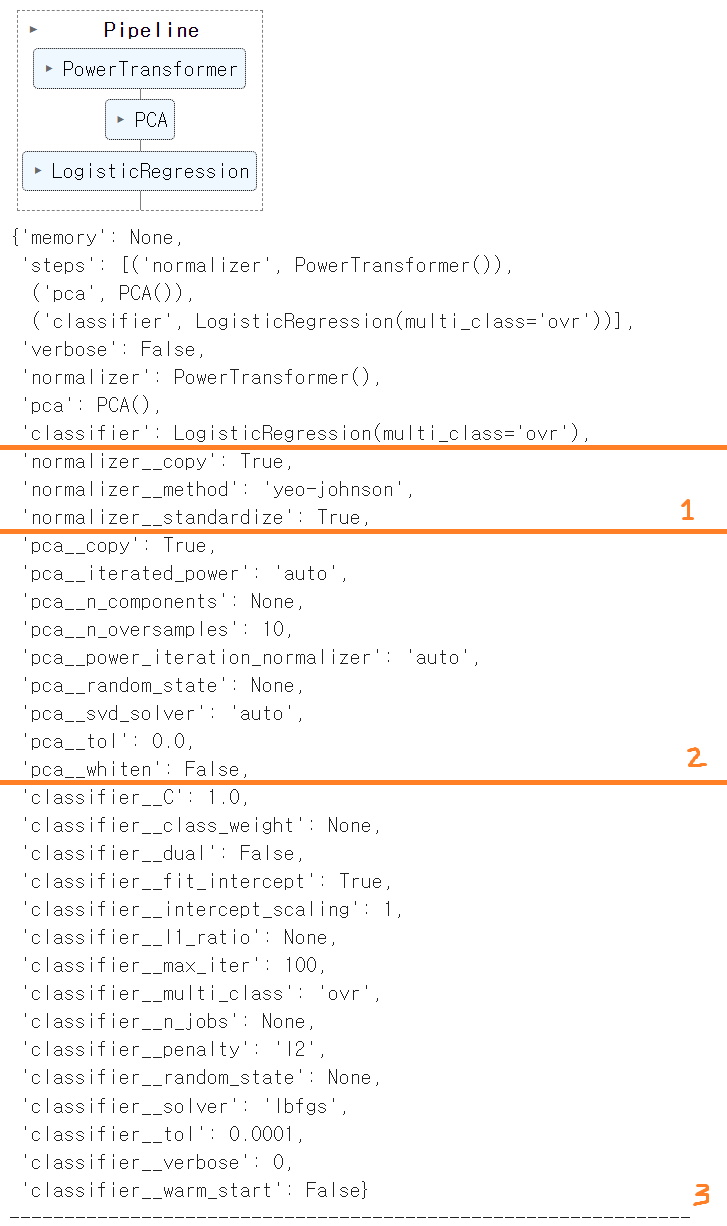

1, 2, 3으로 표시한 부분을 보겠습니다.

1번은 pipeline에서 'normalizer'라고 이름 붙인 단계 즉, PowerTransformer에 해당하는 parameter입니다.

2번은 pca에 대한 parameter, 3번은 classifer에 대한 parameter입니다.

LRclassifier에 대한 parameter를 튜닝하고 싶다면, classifier__xx 라고 이름 붙은 속성들을 주목하면 되겠습니다.



classifier 별 어떤 parameter가 있는지는 다음 하이퍼링크를 참고하시면 됩니다.

[LogisticRegression](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LogisticRegression.html)

[LinearDiscriminantAnalysis](https://scikit-learn.org/stable/modules/generated/sklearn.discriminant_analysis.LinearDiscriminantAnalysis.html)

[Random Forest Classifier](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestClassifier.html#sklearn.ensemble.RandomForestClassifier)

[lightGBM](https://lightgbm.readthedocs.io/en/latest/pythonapi/lightgbm.LGBMClassifier.html)

[SVC](https://scikit-learn.org/stable/modules/generated/sklearn.svm.SVC.html#sklearn.svm.SVC)


LogisticRegression의 penalty 부분은 다음과 같이 적혀 있습니다.

penalty{‘l1’, ‘l2’, ‘elasticnet’, None}, default=’l2’

즉 penalty 로는 l1, l2, elasticnet, none 의 인자 중 하나를 넣을 수 있고 default는 l2 라는 뜻 입니다.

이제 LRclassifer의 'penalty' 부분을 tuning 하고 싶다고 가정합니다.

그렇다면 grid_param_lr 을 다음과 같이 지정해두면 됩니다.


```
grid_param_lr = [{
    'classifier__penalty': ['l1', 'l2', 'elasticnet', None],
}]
```

이런 식으로 매뉴얼 문서 상의 parameter에 대한 정의, 속성을 보고 튜닝 해보고 싶은 값을 지정해서 넣으면 됩니다.

np.arange, np.logspace 등의 함수를 이용하여 float나 interger 속성을 가지는 값들에 대해 균등한 리스트를 만들어 두고 최적값을 찾도록 할 수도 있습니다.

In [ ]:
#Setting parameters
min_samples_split_range = [0.5, 0.7 , 0.9]
param_range = [0.5, 0.1]
param_range_fl = np.logspace(0,-5,5)

grid_param_lr = [{
    'classifier__penalty': ['l1', 'l2'],
    'classifier__C': param_range_fl,
}]

grid_param_lda = [{
    "classifier__tol" : param_range_fl,
    "classifier__solver" : ["svd","lsqr","eigen"]
}]

grid_param_rf = [{

}]

grid_param_gbm = [{

}]

grid_param_svc = [{

}]

## tuning 할 classifier만 골라서 지정합니다.
paramList = []#[grid_param_lr, grid_param_lda, grid_param_rf, grid_param_gbm, grid_param_svc]

In [33]:
from sklearn.model_selection import GridSearchCV

grid_param_rf = [{
'classifier__n_estimators' : [200,400,600,800,1000],
'classifier__criterion' : ["gini"],
'classifier__max_depth' : [10,50,100,300,500,700,1000],
'classifier__min_samples_split' : [5],
'classifier__ccp_alpha':[0.0]
}]

paramList = [grid_param_rf]
for clf, p in zip(modelList, paramList):
  gscv = GridSearchCV(
      estimator = clf,
      param_grid = p,
      scoring='f1_macro',     # Scoring with macro F1 score
      cv=LeaveOneGroupOut(),  # Subject-wise cross-validation
      n_jobs=-1,              # Enable multiprocessing
      verbose=10,
  )
  exclude = [3,7,11,18,21,26,30,33,37,40]
  allpara = list(range(X_features.shape[1]))
  real = [x for x in allpara if x not in  exclude]

  gscv.fit(X_features[:,real], Y, groups=Subjects)
  print(f'Best Alpha: {gscv.best_params_}, Best score: {gscv.best_score_}')

Fitting 7 folds for each of 35 candidates, totalling 245 fits


/usr/local/lib/python3.10/dist-packages/joblib/externals/loky/process_executor.py:752: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


Best Alpha: {'classifier__ccp_alpha': 0.0, 'classifier__criterion': 'gini', 'classifier__max_depth': 10, 'classifier__min_samples_split': 5, 'classifier__n_estimators': 1000}, Best score: 0.677814500806156


In [ ]:
#100,200,300,500,600,700,1000 -> 600
#gini , entropy -> gini
#10,50,100,200,300,500,700,1000 -> 1000
#2,5,7,10,20,50 -> 5
#0.0,0.01,0.02,0.03,0.05,0.07,0.1, 0.2, 0.5 -> 0
#0.6762383395319962

#200,400,600,800,1000 -> 600 or 800
#gini
#10,50,100,300,500,700,1000 -> 1000
#5
#0.0

#0.6672399796332128


#Best Alpha: {'classifier__ccp_alpha': 0.0,
# 'classifier__criterion': 'gini',
#'classifier__max_depth': 10,
#'classifier__min_samples_split': 5,
#'classifier__n_estimators': 1000},
#Best score: 0.677814500806156

In [ ]:
# -7

#### feature search with forward selection

In [24]:
import pandas as pd
from tqdm.notebook import tqdm


def arr2df():
  df = pd.DataFrame(X_features)
  print(df)
  pass


def subset_search():
  np.set_printoptions(formatter={'float_kind': lambda x: "{0:0.3f}".format(x)})
  labels = Y
  inputs = X_features

  pre_index = [3,7,11,18,21,26,30,33,37,40]


  remaining_features = set(range(inputs.shape[1])) - set(pre_index)
  features = inputs[:,list(remaining_features)]
  scores_list = [0]
  features_list = list(remaining_features)
  best_ever = np.zeros(2)



  for k in tqdm(range(1, inputs.shape[1] - len(pre_index) + 1)):
    print('-----------------------------------------------------------')
    best_scores = 0
    # Looping over all possible combinations: from 11 choose k
    for f in remaining_features:
      stage_feature = list(remaining_features.copy())
      stage_feature.remove(f)
      score_th = 0

      x_temp =   inputs[:,stage_feature]
      # validation only on LRClassifier
      scores = cross_val_score(RFClassifier,
                                x_temp, labels,
                                groups=Subjects,        # Provide subjects for subject-wise cross-validation
                                cv=LeaveOneGroupOut(),  # Subject-wise cross-validation
                                scoring='f1_macro',     # Scoring with macro F1 score
                                n_jobs=-1,              # Enable multiprocessing
                                )
      m = np.mean(scores)
      print(f'({k}:{f}) {scores} ... {m:.3f}')
      score_th += m
      score_th = (score_th / 2)
      if m >= best_scores:
        best_scores = m
        best_feature = stage_feature
      if best_scores >= best_ever[1]:
        best_ever[0] = k
        best_ever[1] = best_scores
      if best_scores > 0.75:
        best_feature = stage_feature
        break

    scores_list.append(best_scores)                  # Append lists
    features_list = best_feature

    remaining_features = features_list
    print(f"Round{k}: {features_list}")

  # Print the result
  print(f'--------------------------------------')
  print(f'best score at Round #{best_ever[0]}: {best_ever[1]}')
  print(f'--------------------------------------')
  print(f'scores: {scores_list}')
  print(f'features: {features_list}')
  print(f'{features.shape}')
  print(f'--------------------------------------')


subset_search()

  0%|          | 0/40 [00:00<?, ?it/s]

-----------------------------------------------------------
(1:0) [0.654 0.615 0.616 0.699 0.665 0.792 0.234] ... 0.611
(1:1) [0.490 0.599 0.620 0.695 0.753 0.792 0.325] ... 0.611
(1:2) [0.575 0.615 0.632 0.792 0.732 0.791 0.187] ... 0.618
(1:3) [0.573 0.636 0.624 0.750 0.742 0.809 0.325] ... 0.637
(1:4) [0.548 0.614 0.631 0.776 0.740 0.802 0.322] ... 0.633
(1:5) [0.520 0.617 0.620 0.791 0.735 0.799 0.325] ... 0.630
(1:6) [0.494 0.592 0.619 0.770 0.745 0.804 0.325] ... 0.621
(1:8) [0.540 0.630 0.628 0.784 0.731 0.798 0.243] ... 0.622
(1:9) [0.514 0.601 0.633 0.705 0.721 0.803 0.491] ... 0.639
(1:10) [0.479 0.610 0.634 0.767 0.740 0.797 0.491] ... 0.646
(1:11) [0.561 0.613 0.625 0.794 0.732 0.797 0.491] ... 0.659
(1:12) [0.511 0.592 0.644 0.774 0.743 0.801 0.491] ... 0.651
(1:13) [0.607 0.607 0.639 0.782 0.752 0.797 0.172] ... 0.622
(1:14) [0.503 0.640 0.618 0.764 0.746 0.801 0.487] ... 0.651
(1:15) [0.598 0.648 0.629 0.703 0.671 0.816 0.325] ... 0.627
(1:16) [0.617 0.610 0.631 0.774 0.

KeyboardInterrupt: ignored

#####Cross-validation Again with selected features

In [ ]:
from sklearn.preprocessing import FunctionTransformer

def select_features(features, indices=None):
    if indices is None:
        indices = [i for i in range(features.shape[1])]
    return features[:, indices]

feature_selector = FunctionTransformer(select_features)
feature_selector.set_params(
    kw_args={'indices': [0,2,3,4,21,22,32]}
)

# modelList is defined above
for m in modelList:
  modelWithFs = Pipeline([
      ('fs', feature_selector),
      ('clf', m),
  ])
  display(modelWithFs.get_params())

  scores = cross_val_score(
      modelWithFs,
      X_features, Y,
      groups=Subjects,        # Provide subjects for subject-wise cross-validation
      cv=LeaveOneGroupOut(),  # Subject-wise cross-validation
      scoring='f1_macro',     # Scoring with macro F1 score
      n_jobs=-1,              # Enable multiprocessing
      verbose=10,             # Print processing logs
  )
  print(scores)
  print("------------")
  print(np.mean(scores))

### 5. Cross-validation with Subjects

In [35]:
#################### TODO: Implement your own classifiers ####################
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import FunctionTransformer, StandardScaler, PowerTransformer
from sklearn.decomposition import PCA
from sklearn.linear_model import LogisticRegression
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.ensemble import RandomForestClassifier
from lightgbm import LGBMClassifier
from sklearn.svm import SVC


LRClassifier = Pipeline([
    ('normalizer', PowerTransformer()),
    ('pca', PCA()),
    ('classifier', LogisticRegression(multi_class='ovr')),
])

LDAClassifier = Pipeline([
    ('normalizer', StandardScaler()),
    ('classifier', LinearDiscriminantAnalysis()),
])

RFClassifier = Pipeline([
    ('fs', feature_selector),
    ('normalizer', StandardScaler()),
    ('pca', PCA()),
    ('classifier', RandomForestClassifier(n_estimators= 600,
                                          max_depth=10,
                                          min_samples_split= 5)),
])

BClassifier = Pipeline([
    ('normalizer', StandardScaler()),
    ('classifier', LGBMClassifier())
])


SVMClassifier = Pipeline([
    ('normalizer', StandardScaler()),
    ('pca', PCA()),
    ('classifier', SVC()),
])
##############################################################################

NameError: ignored

In [37]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import FunctionTransformer, StandardScaler, PowerTransformer
from sklearn.decomposition import PCA
from sklearn.linear_model import LogisticRegression
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.ensemble import RandomForestClassifier
from lightgbm import LGBMClassifier
from sklearn.svm import SVC
RFClassifier = Pipeline([
    ('normalizer', StandardScaler()),
    ('pca', PCA()),
    ('classifier', RandomForestClassifier(n_estimators= 2000,
                                          max_depth=15)),
])

for clf in [RFClassifier] :#[LRClassifier, LDAClassifier, RFClassifier, BClassifier, SVMClassifier]:
    scores = cross_val_score(
        clf,
        X_features, Y,
        groups=Subjects,        # Provide subjects for subject-wise cross-validation
        cv=LeaveOneGroupOut(),  # Subject-wise cross-validation
        scoring='f1_macro',     # Scoring with macro F1 score
        n_jobs=-1,              # Enable multiprocessing
        verbose=10,             # Print processing logs
    )
    print(scores)
    print("------------")
    print(np.mean(scores))

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:  4.2min
[Parallel(n_jobs=-1)]: Done   4 tasks      | elapsed:  8.6min
[Parallel(n_jobs=-1)]: Done   5 out of   7 | elapsed: 12.4min remaining:  5.0min


[0.54252843 0.61050782 0.64090572 0.80693622 0.74804887 0.81087525
 0.49137931]
------------
0.6644545175591591


[Parallel(n_jobs=-1)]: Done   7 out of   7 | elapsed: 15.9min finished


In [ ]:
#org para
#2000/ 15
#0.6848500768540983

#
#0.6644545175591591


